# Part 2: Character-Level RNN-Based Text Classification Model

Implemnation of character-level RNN models that are used to classify the nationality of names.

## Import packages

In [1]:
import torch
import torch.nn as nn
import random
from rnn2_utils import *

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

print('num of classes:', n_categories)
print('num of letters:', n_letters)

num of classes: 18
num of letters: 57


---
## Task 7.3 Defining the network

Defined a single directional RNN model.

- An RNN cell `rnn_cell`, a fully-connected layer `self.fc`, and a softmax layer `self.softmax` are defined in `__init__()`
- The computational graph is defined in `forward()`. The hidden state of the RNN cell is stored in the tensor `h`, which is of size `[batch_size, hidden_size]`. `forward()` takes as input the tensor `x` in of size `[seq_length, batch_size, input_size]`, whose first dimension is the time steps. Therefore, we use a `for` loop to iterate over the time steps, and for each time step, we feed the input at the current step, and the previous hidden state to the RNN cell. The cell then returns a new hidden state, which overrides `h`.

In [3]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        """
        x: size [seq_length, 1, input_size]
        """
        h = torch.zeros(x.size(1), self.hidden_size)
        
        for i in range(x.size(0)):
            h = self.rnn_cell(x[i],h)
            
        out = self.softmax(self.fc(h))
        
        return out

In [4]:
# Evaluate Task 7.3
torch.manual_seed(0)
rnn = RNN(10, 20, 18)
input_data = torch.randn(6, 3, 10)

with torch.no_grad():
    out = rnn(input_data)
    
print(out.size())
print(out[0])

torch.Size([3, 18])
tensor([-3.3146, -3.0216, -2.9363, -3.1215, -2.7141, -2.7103, -2.9526, -3.0657,
        -2.9442, -3.0038, -2.6818, -2.7880, -2.9849, -3.1164, -2.5659, -2.5336,
        -2.9586, -2.9764])


## Task 7.4 Training the model


Train the model with stachastic gradient descent. One data example is used per iteration, i.e., the mini-batch size is 1.

- Each training data example contains a name (`x`) and a label indicating its nationality (`y`). 
- The model uses the tensor version of `x` and `y`, i.e., `x_tensor` and `y_tensor`. Here `x_tensor` is of size `[seq_length, 1, input_size]`, in which `input_size` is the total number of letters.
- `x_tensor[0, 0, :]` as the one-hot encoding for the first letter in the string `x`, and so forth for `x_tensor[1, 0, :]` etc.
- The function will output the predicing result every 5000 iterations. 

In [5]:
def train(model, n_iters = 100000, print_every = 5000, plot_every = 1000, learning_rate = 0.005):
    # Turn on the training model
    model.train()
    
    # Loss and optimizer
    criterion = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    
    running_loss = 0
    all_losses = []
    
    # Train loop
    start = time.time()
    for i in range(n_iters):
        y, x, y_tensor, x_tensor = randomTrainingExample()
        
        # zero grad
        optimizer.zero_grad()
        
        # Forward pass
        output = model(x_tensor) 
        loss = criterion(output,y_tensor)
        
        # Backprop and update
        loss.backward()
        optimizer.step()
        
        # Record loss
        running_loss += loss.item()
        
        # Print iter, loss, name, and guess
        if i % print_every == 0 and i > 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == y else '✗ (%s)' % y
            print('%d %d%% (%s) %.4f %s / %s %s' % (i, i / n_iters * 100, timeSince(start), loss, x, guess, correct))
        
        # Append loss
        if i % plot_every == 0 and i > 0:
            all_losses.append(running_loss / plot_every)
            running_loss = 0
    
    # Plot
    plt.figure()
    plt.plot(all_losses)

C:\Users\munge\anaconda3\lib\site-packages\torch\autograd\__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


5000 5% (0m 10s) 2.8908 Jacques / Greek ✗ (French)
10000 10% (0m 19s) 1.7356 Mcmahon / Irish ✓
15000 15% (0m 29s) 1.7122 Ferreira / Spanish ✗ (Portuguese)
20000 20% (0m 38s) 2.6051 Finn / Chinese ✗ (Irish)
25000 25% (0m 48s) 2.8467 Arian / Scottish ✗ (Arabic)
30000 30% (0m 57s) 0.0768 Takahama / Japanese ✓
35000 35% (1m 7s) 0.0167 Antimisiaris / Greek ✓
40000 40% (1m 17s) 1.3374 Chlebek / Czech ✗ (Polish)
45000 45% (1m 27s) 1.8558 Robles / Dutch ✗ (Spanish)
50000 50% (1m 37s) 0.4252 OuYang / Chinese ✓
55000 55% (1m 47s) 0.1350 Issa / Arabic ✓
60000 60% (1m 57s) 1.5986 Ton / Korean ✗ (Vietnamese)
65000 65% (2m 7s) 0.4888 Kaibara / Japanese ✓
70000 70% (2m 17s) 2.1009 Cormac / Czech ✗ (Irish)
75000 75% (2m 28s) 0.5329 Waldvogel / German ✓
80000 80% (2m 38s) 0.1877 Azarola / Spanish ✓
85000 85% (2m 50s) 0.6457 Cathan / Irish ✓
90000 90% (3m 0s) 1.6865 Mikhailyants / Dutch ✗ (Russian)
95000 95% (3m 10s) 1.2736 Lauwers / English ✗ (Dutch)


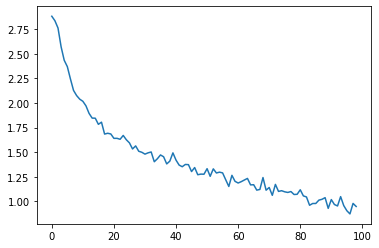

In [6]:
# Evaluate Task 7.4
# Be patient with the training speed :)
torch.manual_seed(0)
random.seed(0)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

train(rnn)

## Task 7.5 Bi-directional RNN model

Implementation of a bi-directional RNN model by modifying the architecture of the `RNN` class.

- Two distinct RNN cells are defined in `__init__()`. The input size for the fully-connected layer is doubled, because it needs take input the concatenated hidden states from the two cells.
- In `forward()`, two hidden states, `h1` and `h2`, are computed separately. `h1` is exactly the same as the previous `h` in one-directional `RNN`. `h2` is computed by reversing the order of the `for` loop: iterating from the last time step to the first time step.
- Concatenate `h1` and `h2` using `torch.cat()`.

In [7]:
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.rnn_cell1 = nn.RNNCell(input_size, hidden_size)
        self.rnn_cell2 = nn.RNNCell(input_size, hidden_size)
        
        self.fc = nn.Linear(2 * hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        """
        x: size [seq_length, 1, input_size]
        """
        h1 = torch.zeros(x.size(1), self.hidden_size)
        for i in range(x.size(0)):
            h1 = self.rnn_cell1(x[i], h1)
        
        h2 = torch.zeros(x.size(1), self.hidden_size)
        for i in reversed(range(x.size(0))): # Hint: reverse the order of the for loop
            h2 = self.rnn_cell2(x[i], h2)
        
        h = torch.cat((h1, h2),1)
        out = self.softmax(self.fc(h))
        
        return out

5000 5% (0m 18s) 3.1154 Jacques / Greek ✗ (French)
10000 10% (0m 38s) 1.5236 Mcmahon / Scottish ✗ (Irish)
15000 15% (0m 57s) 1.4322 Ferreira / Spanish ✗ (Portuguese)
20000 20% (1m 15s) 2.2772 Finn / Chinese ✗ (Irish)
25000 25% (1m 32s) 1.1499 Arian / Arabic ✓
30000 30% (1m 50s) 0.0653 Takahama / Japanese ✓
35000 35% (2m 7s) 0.0596 Antimisiaris / Greek ✓
40000 40% (2m 25s) 1.3657 Chlebek / Czech ✗ (Polish)
45000 45% (2m 42s) 1.9852 Robles / Dutch ✗ (Spanish)
50000 50% (2m 59s) 0.0468 OuYang / Chinese ✓
55000 55% (3m 16s) 0.0540 Issa / Arabic ✓
60000 60% (3m 34s) 1.5942 Ton / Korean ✗ (Vietnamese)
65000 65% (3m 51s) 0.3659 Kaibara / Japanese ✓
70000 70% (4m 9s) 3.7787 Cormac / French ✗ (Irish)
75000 75% (4m 27s) 1.5433 Waldvogel / Czech ✗ (German)
80000 80% (4m 45s) 0.1893 Azarola / Spanish ✓
85000 85% (5m 2s) 0.4187 Cathan / Irish ✓
90000 90% (5m 20s) 1.6979 Mikhailyants / Greek ✗ (Russian)
95000 95% (5m 38s) 1.6534 Lauwers / English ✗ (Dutch)


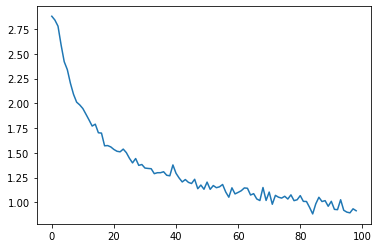

In [8]:
# Evaluate Task 7.5
# Be even more patient, as the training time is almost doubled :P
torch.manual_seed(0)
random.seed(0)

n_hidden = 128
birnn = BiRNN(n_letters, n_hidden, n_categories)

train(birnn)

In [9]:
def evaluate(model, x_tensor):
    model.eval()
    with torch.no_grad():
        output = model(x_tensor)
    return output


def predict(model, input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(model, lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [10]:
predict(birnn, 'Jose')
predict(rnn, 'Jose')

predict(birnn, 'Robinhood')
predict(rnn, 'Robinhood')

predict(birnn, 'Zhang')
predict(rnn, 'Zhang')

predict(birnn, 'Park')
predict(rnn, 'Park')


> Jose
(-1.19) French
(-1.45) English
(-2.23) Scottish

> Jose
(-0.94) German
(-1.70) English
(-2.09) Korean

> Robinhood
(-1.17) English
(-1.19) Scottish
(-2.16) Dutch

> Robinhood
(-0.05) Scottish
(-3.91) English
(-4.79) Dutch

> Zhang
(-0.16) Chinese
(-2.26) Korean
(-3.21) Vietnamese

> Zhang
(-0.38) Chinese
(-1.32) Korean
(-3.51) Vietnamese

> Park
(-0.67) Dutch
(-1.96) German
(-1.97) Czech

> Park
(-0.26) Dutch
(-2.86) Polish
(-3.21) English
